## train.ipynb: Define and Train the model
- 更新数据读取方式

In [1]:
# Import the necessary libraries
import numpy as np
import scipy
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cross_validation import StratifiedKFold

In [2]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features  n
numPCAcomponents = 30
# Patches windows size
windowSize = 5
# The proportion of Test sets
trainRatio = 200
# The batch_szie
batch_size = 16

## 用glob 库进行读取

In [3]:
import glob

In [4]:
data_dir= "./predata200"
data_root = glob.glob(data_dir + '/*')
print(data_root)

['./predata200\\X_all_WS_5_PCA_30_trainRatio_200.npy', './predata200\\X_label_WS_5_PCA_30_trainRatio_200.npy', './predata200\\X_train_WS_5_PCA_30_trainRatio_200.npy', './predata200\\Y_all_WS_5_PCA_30_trainRatio_200.npy', './predata200\\Y_label_WS_5_PCA_30_trainRatio_200.npy', './predata200\\Y_train_WS_5_PCA_30_trainRatio_200.npy']


In [5]:
for name in glob.glob(data_dir + '/*'):
    print(name)

./predata200\X_all_WS_5_PCA_30_trainRatio_200.npy
./predata200\X_label_WS_5_PCA_30_trainRatio_200.npy
./predata200\X_train_WS_5_PCA_30_trainRatio_200.npy
./predata200\Y_all_WS_5_PCA_30_trainRatio_200.npy
./predata200\Y_label_WS_5_PCA_30_trainRatio_200.npy
./predata200\Y_train_WS_5_PCA_30_trainRatio_200.npy


In [6]:
# 则是一种导入特定数据的方法，没有毛病
X_train = np.load(data_root[2])
X_label = np.load(data_root[1])
Y_train = np.load(data_root[5])
Y_label = np.load(data_root[4])

In [7]:
X_train.shape, X_label.shape, Y_train.shape, Y_label.shape

((730, 5, 5, 30), (730,), (10049, 5, 5, 30), (10049,))

In [8]:
# Reshape data into (numberofsumples, channels, height, width)

# convert class labels to on-hot encoding
X_label = utils.to_categorical(X_label)
Y_label = utils.to_categorical(Y_label)

In [10]:
X_train.shape, X_label.shape, Y_train.shape, Y_label.shape

((730, 5, 5, 30), (730, 16), (10049, 5, 5, 30), (10049, 16))

In [12]:
X_train.dtype, X_label.dtype, Y_train.dtype, Y_label.dtype

(dtype('float64'), dtype('float32'), dtype('float64'), dtype('float32'))

In [13]:
db_train = tf.data.Dataset.from_tensor_slices((X_train, X_label))
db_test = tf.data.Dataset.from_tensor_slices((Y_train, Y_label))

db_train = db_train.shuffle(7919).batch(batch_size=batch_size).repeat()
db_test = db_test.batch(batch_size=batch_size)

In [14]:
db_train

<RepeatDataset shapes: ((None, 5, 5, 30), (None, 16)), types: (tf.float64, tf.float32)>

In [21]:
# Define the model structure
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='softmax'))

orgin shape (None, 5, 5, 128)
afte Conv2D (None, 5, 5, 256)
afte Conv2D (None, 5, 5, 256)


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(128, (3, 3), input_shape=(5,5,204), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
print("orgin shape", model.output.shape)
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
print("afte Conv2D", model.output_shape)
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D()      # 不能添加
print("afte Conv2D", model.output_shape)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(17, activation='softmax', name='Salinas_Output'))  

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 5, 5, 128)         235136    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 256)         295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 256)         590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)             

In [23]:
# Define optimization and train method

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=10, min_lr=0.000001, verbose=1)
# checkpointer = ModelCheckpoint(filepath=".\checkP\.checkpoint.ckpt", verbose=1, save_best_only=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [24]:
epoch = 50

In [25]:
# Start to train model 
history = model.fit(db_train,
                    batch_size=batch_size, 
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    epochs=epoch, 
                    validation_data=db_test, 
                    validation_steps=Y_train.shape[0]//batch_size,
                    callbacks=[reduce_lr])

Epoch 1/50


ValueError: in user code:

    C:\ProgramData\Miniconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Miniconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Miniconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Miniconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Miniconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Miniconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Miniconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\ProgramData\Miniconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\ProgramData\Miniconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 204 but received input with shape [None, 5, 5, 30]


In [45]:
# save the model with h5py
model.save('./model/HSI_model5.h5')

In [46]:
# using plot_model module to save the model figure
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./model/model5.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [36]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


In [ ]:
# show the model figure
model_img = plt.imread('./model/model5.png')
# plt.figure(dpi=180)
plt.imshow(model_img)
plt.show()

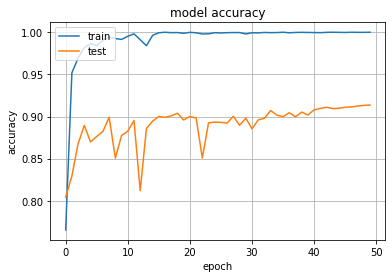

In [40]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
# plt.savefig("./result/model_accuracy_100.svg")
plt.show()

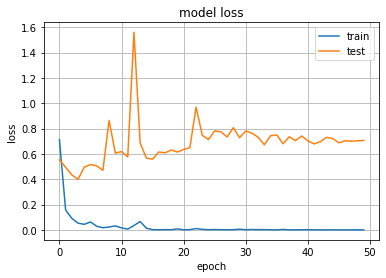

In [41]:
# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper right') 
# plt.savefig("./result/model_loss_100.svg")
plt.show()